# Importations 


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque, namedtuple
SEED = 77
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim
from utils.environment import *
from utils.utils import *
CATALOGUE_SIZE = 50

### Load the environment and results from q learning algorithm

In [2]:
# Load the environment 
with open('./check/env.pickle', 'rb') as f:
    env = pickle.load(f)


In [3]:
# Load the q_tables for gamma = 0 and gamma = 0.9
with open('./check/q_tables_q_learning_0.pickle', 'rb') as f:
    [q_table_q,q_table_q1] = pickle.load(f)

with open('./check/q_tables_q_learning_09.pickle', 'rb') as f:
    [q_table_q09,q_table_q109] = pickle.load(f)
    
with open('./check/q_learning_rewards_0.pickle', 'rb') as f:
    [all_reward_q0,all_reward_q10] = pickle.load(f)
    
with open('./check/q_learning_rewards_09.pickle', 'rb') as f:
    [all_reward_q09,all_reward_q109] = pickle.load(f)
    
    


In [4]:
tables_q_learning = [q_table_q,q_table_q1,q_table_q09,q_table_q109]

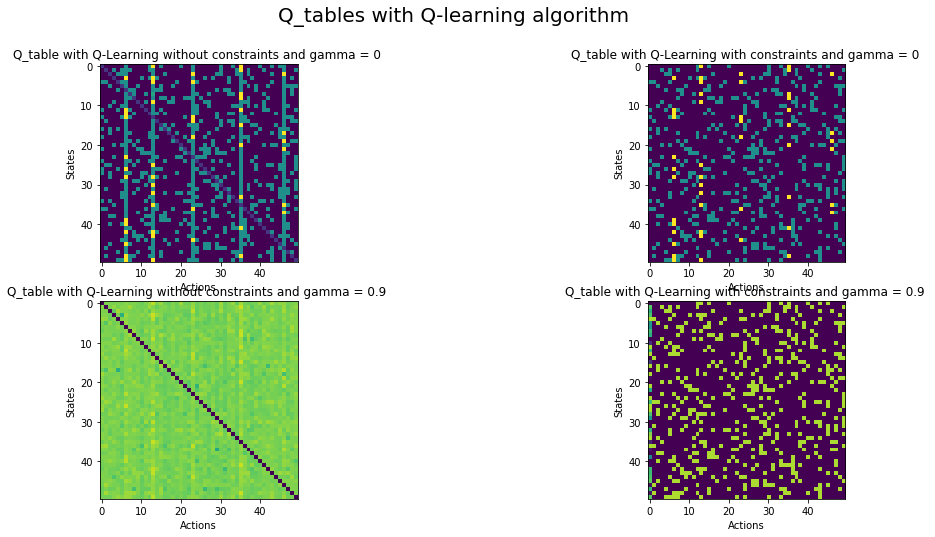

In [5]:
names = ['Q_table with Q-Learning without constraints and gamma = 0 ',\
         'Q_table with Q-Learning with constraints and gamma = 0 ' ,\
        'Q_table with Q-Learning without constraints and gamma = 0.9 ',\
         'Q_table with Q-Learning with constraints and gamma = 0.9 ' ]

f, axs = plt.subplots(2,2,figsize=(18,8))
axs = axs.reshape(-1,1)
    
for i in range(len(axs)) : 

    axs[i][0].imshow(tables_q_learning[i],cmap='viridis', vmin=0, vmax=2)
    axs[i][0].set_xlabel('Actions')
    axs[i][0].set_ylabel('States')
    axs[i][0].set_title(names[i])
        
        

plt.suptitle('Q_tables with Q-learning algorithm ', size=20)    
        
plt.show()

## Reward matrix

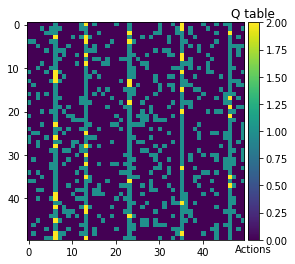

In [7]:
plot_q_table(get_matrix_rewards(env))

## Rewards with Q learning algorithm

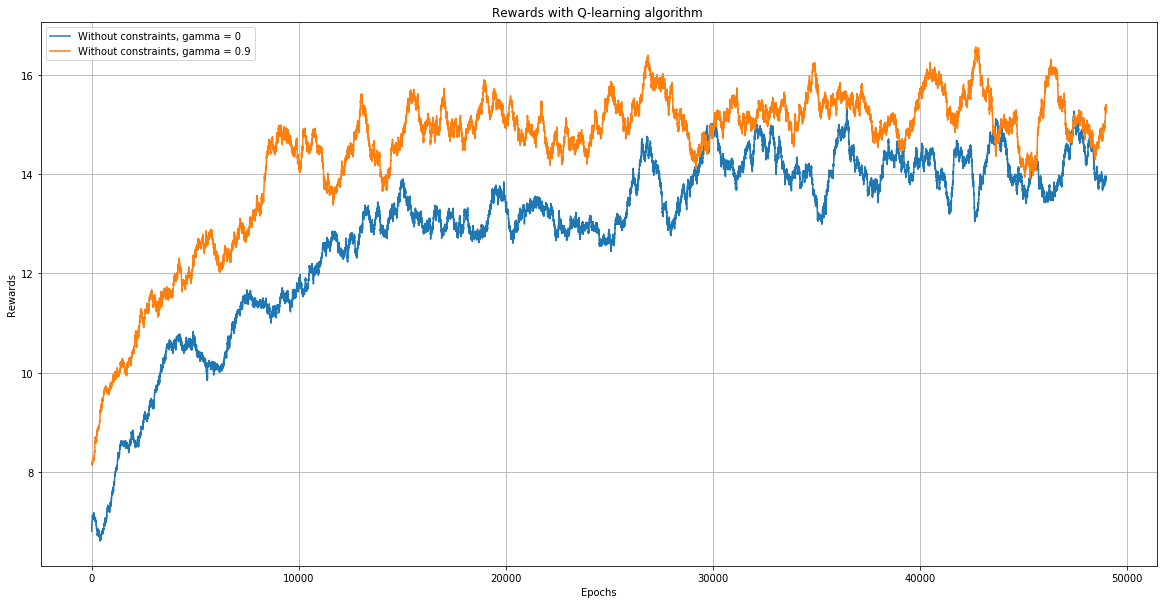

In [8]:
f, axs = plt.subplots(1,1,figsize=(20,10))

# plt.plot( running_mean(all_reward_q0,1000), label ='With constraints, gamma = 0' )
plt.plot( running_mean(all_reward_q10,1000) , label ='Without constraints, gamma = 0')
# plt.plot( running_mean(all_reward_q09,1000), label ='With constraints, gamma = 0.9 ' )
plt.plot( running_mean(all_reward_q109,1000) , label ='Without constraints, gamma = 0.9')

plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.title('Rewards with Q-learning algorithm ')
plt.legend()
plt.grid(True)
plt.show()


# Deep Q learning 

## Dictionnary to know the size of the featured state (used for state representation)

In [9]:
''' Dictionnary conversion '''
# Dictionary with the transformation of states and the size of the states
dict_conversion = {'identity' : 1,'hot_encoding' : CATALOGUE_SIZE , 'u' : CATALOGUE_SIZE ,\
                   'u_hot' : CATALOGUE_SIZE, 'cached' : 1 ,\
                  'rewards' : CATALOGUE_SIZE,'valuable' :CATALOGUE_SIZE , 'multiple' : 3*CATALOGUE_SIZE,\
                  'multiple_valuable' : 4*CATALOGUE_SIZE}

## Experience 

A class to set the observation that will be given to the agent, in order to store it for the Neural Network

In [10]:
'''Experience'''
# A class to denote the experience which will be stored in the memory
Experience =namedtuple('Experience', ('state','action','reward','next_state','done'))


## Memory Replay 

Memory where are stored the experiences 

In [11]:
''' MEMORY  '''
class Memory(object) :
    """ Memory class that stores the experience of the network"""

    def __init__(self, mem_size) :
        # Mem_size is the number of experiences memorized

        self.buffer = deque(maxlen = mem_size)


    def add(self, experience) :
        # Add an element to the memory

        self.buffer.append(experience)

    def sample(self, batch_size) :
        # Sample randomly among the buffer
        if batch_size > self.buffer.maxlen :
            print("Be careful ! We can't sample more than the size of the memory !")
            return None
        elif len(self.buffer) == 0 :
            print('The buffer is empty ')
            return None

        indexes = np.random.choice(np.arange(len(self.buffer)),\
                                  size = batch_size , replace = False)

        return [self.buffer[i] for i in indexes]

    def size(self) :
        return len(self.buffer)

In [12]:

'''Function to pre-train the memory'''

def pre_trained_mem(mem,pre_train_length, env)  :
    # Initialisation of the memory by taking random actions

    for i in range(pre_train_length) :

        state = env.refresh()

        action = random.randrange(0,env.n_actions,1)

        new_state, reward, done = env.step(action,state)

        mem.add(Experience(state,action,reward,new_state,done))



# State representation 

We need a way to represent the states. 

To do so, we created a class that converts a given state into a new representation

In [32]:
'''Pre-processing of the states'''


class ConversionState(object) :
    """
    Class that is used to convert state into a new representation
    """
    def __init__(self,  env, name_function, CATALOGUE_SIZE  = CATALOGUE_SIZE) :
        """
        Inputs :

        env : The Environment that simulates the user
        name_function : The name of the function that is used to do the conversion
        CATALOGUE_SIZE : The size of the catalogue
        """

        self.CATALOGUE_SIZE = CATALOGUE_SIZE
        self.env = env
        self.valuable_representation = self.valuable_actions(env)
        self.conversion = self.choose_function(name_function)
        self.multiple_representation = self.convert_multiple(env)
        self.multiple_val_representation = self.convert_multiple_val(env)



    def choose_function(self,name_function) :

        if name_function == 'identity' :
            return self.identity
        elif name_function == 'hot_encoding' :
            return self.hot_encoding
        elif name_function == 'u' :
            return self.convert_u
        elif name_function == 'cached' :
            return self.convert_cached
        elif name_function == 'u_hot' :
            return self.convert_u_hot
        elif name_function == 'rewards' :
            return self.convert_reward
        elif name_function == 'valuable' :
            return self.valuable
        elif name_function == 'multiple' :
            return self.multiple
        elif name_function =='multiple_valuable' :
            return self.multiple_valuable


    def multiple_valuable(self, state) :
        '''
        Input : An integer that represents the state
        Output : A new representation of the state. For each action, we encode it as :
        (a,b,c,d) where a = 0 if not cached not related, 1 otherwise
                b = 1 if the action is related, 0 otherwise
                c = 1 if the action is cached, 0 otherwise
                d is incremented each time the next action has related contents cached
        '''
        return self.multiple_val_representation[state].view(1,-1 )

    def multiple(self, state) :
        '''
        Input : An integer that represents the state
        Output : A new representation of the state. For each action, we encode it as :
        (a,b,c) where a = 0 if not cached not related, 1 otherwise
                b = 1 if the action is related, 0 otherwise
                c = 1 if the action is cached, 0 otherwise
        '''

        return self.multiple_representation[state].view(1,-1)



    def valuable_actions(self,env) :
        '''
        Input : environment
        Output : A representation of the states where each action is increased by 1 when this action is a content either :
        - related
        - cached
        - Lead to a content cached
        '''


        states = torch.zeros((env.n_states,env.n_actions),dtype = torch.float)

        cost = env.cost

        for state in range(states.shape[0]) :

            for i,x in enumerate(cost) :

                if x == 0 :

                    states[state,i] +=1

        related = env.recommended

        for i in range(states.shape[0]) :

            for new_state in related[i] :

                states[i,new_state] += 1

                for k in related[new_state] :
                    if cost[k] == 0 :
                        states[i,new_state] += 1

        return states

    def valuable(self, state) :

        return self.valuable_representation[state,:].view(1,CATALOGUE_SIZE)



    def identity(self, state) :
        '''
        Input : index of the state
        Output : The same state but in TENSOR
        '''
        if state < self.CATALOGUE_SIZE :

            return Tensor([state]).view(-1,1)

        else :
            print('ERROR IN CONVERTION STATE : STATE > CATALOGUE SIZE')
            return None

    def hot_encoding(self, state) :
        '''
        Input : index of the state
        Output : One hot encoding of the state in TENSOR FORMAT
        '''

        if state < self.CATALOGUE_SIZE :
            # Do the encoding
            state_hot_encoded = np.zeros((1,self.CATALOGUE_SIZE))
            state_hot_encoded[0,state] = 1

            return torch.from_numpy(state_hot_encoded).float()
        else :
            print('ERROR IN CONVERTION STATE : STATE > CATALOGUE SIZE')
            return None


    def convert_u(self, state) :
        '''
        Input : index of the state
        Output : Tensor of size the CATALOGUE_SIZE and with the n most related u values
        '''

        new_states = torch.zeros((1, CATALOGUE_SIZE), dtype = torch.float)

        for x in self.env.recommended[state] :

            new_states[0,x] = self.env.u[state, x]

        return new_states

    def convert_u_hot(self, state) :
        '''
        Input : index of the state
        Output : Tensor of size the CATALOGUE_SIZE and with 1 for the n most related u values
        '''

        new_states = torch.zeros((1, CATALOGUE_SIZE), dtype = torch.float)

        for x in self.env.recommended[state] :

            new_states[0,x] = 1

        return new_states


    def convert_cached(self, state) :
        '''
        Input : index of the state
        Output : Tensor of size 1 which says wheter the state is cached or not
        '''
        return Tensor([ not self.env.cost[state]  ]).view(-1,1)


    def convert_reward(self,state) :
        '''
        Input : index of the state
        Output : Reward matrix of the given state : +1 when this is related and +1 when this is cached
        '''

        new_states = self.convert_u_hot(state)
        indexes = np.where(self.env.cost == 0)[0]
        for x in indexes :
            new_states[0,x] +=1

        return new_states


    def convert_multiple(self, env) :

        related = env.recommended
        cost = env.cost

        representation = torch.zeros((CATALOGUE_SIZE , CATALOGUE_SIZE,3), dtype = torch.float)

        for i in range(CATALOGUE_SIZE) :
            for j in range(CATALOGUE_SIZE) :

                is_related = j in related[i]
                is_cached = cost[j] == 0


                if (not is_cached) and (not is_cached ):
                    representation[i][j][0] = 1
                else :
                    representation[i][j][0] = 0
                if is_related :
                    representation[i][j][1] = 1
                else :
                    representation[i][j][1] = 0

                if is_cached :
                    representation[i][j][2] = 1
                else :
                    representation[i][j][2] = 0


        return representation.view(-1, 3 * CATALOGUE_SIZE)


    def convert_multiple_val(self, env) :

        related = env.recommended
        cost = env.cost

        representation = torch.zeros((CATALOGUE_SIZE , CATALOGUE_SIZE,4), dtype = torch.float)

        for i in range(CATALOGUE_SIZE) :
            for j in range(CATALOGUE_SIZE) :

                is_related = j in related[i]
                is_cached = cost[j] == 0


                if (not is_cached) and (not is_cached ):
                    representation[i][j][0] = 1
                else :
                    representation[i][j][0] = 0
                if is_related :
                    representation[i][j][1] = 1
                else :
                    representation[i][j][1] = 0

                if is_cached :
                    representation[i][j][2] = 1
                else :
                    representation[i][j][2] = 0

                representation[i][j][3] = 0

                for k in related[j] :
                    if cost[k] == 0 :
                        representation[i][j][3] += 1



        return representation.view(-1, 4 * CATALOGUE_SIZE)




# Environment 

The environment which is a simulation of a Markovian User 

In [33]:

''' Environment '''
class Environment(object) :
    # Creates an environmnent
    # For us, this is the behavior of the User
    def __init__(self,n_actions,  n_states, alpha, to_leave, n_recommended, n_cached,\
                rewards,SEED=77, u=None, cost = None) :
        self.SEED = SEED
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        # Alpha is the coefficient in which a user chooses a recommended content
        self.to_leave = to_leave
        # to_leave is the coefficient in which a user decides to quit the process
        #self.state = np.array([i for i in range(n_states)])
        self.n_recommended = n_recommended
        # n_recommend corresponds to the number of content to recommend. HERE, WE DON'T USE IT YET
        self.n_cached = n_cached
        # n_cached correponds to the number of cached content
        #self.index_recommended = create_matrix_u(self.n_states,self.n_actions,self.n_recommended)
        #self.index_cached = create_matrix_u(self.n_states,self.n_actions,self.n_cached)
        self.u = creation_u(self.n_states) if u is None else u
        # U matrix which denotes the similarity score
        self.cost = creation_caching(self.n_states, self.n_cached) if cost is None else cost
        # It denotes the cached content (0 if cached, 1 not-cached)
        self.p0 = create_priori_popularity(self.n_states)
        # The probability to choose content j from the catalogue
        self.rewards = rewards
        # List of rewards like [RC, RnC , nRC, nRnC]
        # RC = Recommended & Cached ; nRnC = non Recommended & non Cached
        self.recommended = self.get_index_recommendation()

    def refresh(self,SEED = None) :
        # Reset the state to a new value
        if SEED is not None :
            self.SEED = SEED
        return random.randrange(0,self.n_states,1)

    def reset(self) :
        # Reset the environment to a new random state.
        #It resets both the recommendation and the cached indexes
        # It returns a first state
        self.u = creation_u(self.n_states)
        self.cached = creation_caching(self.n_states, self.n_cached)
        self.p0 = create_priori_popularity(self.n_states)

        return self.state[random.randrange(0,self.n_states,1)]



    def find_reward(self, action,state) :
        # Finds the reward for the given action starting in the given state
        # It tests whether the state is recommended, cached or not

        # It gives from the u matrix whether the action from the state is recommended or not
        if ((state is None) or (action is None) ):
            return 0

        recommended_matrix = self.recommended[state]
        is_cached = get_cached(action, self.cost)

        if ( (action in recommended_matrix) and (is_cached)) :
            # Content recommended and cached : best reward
            return self.rewards[0]
        elif ( (action in recommended_matrix) and ( not is_cached) ) :
            # Content recommended but not cached
            return self.rewards[1]
        elif ( (action not in recommended_matrix ) and (is_cached)) :
            # Content not recommended but cached
            return self.rewards[2]
        else :
            # Content neither recommended nor cached
            return self.rewards[3]


    def step(self, action,state) :
        # Returns the state, reward after taking the action in input
        # done is a boolean to say whether the user quits the game or not
        # We want to return the state where will be the user when we suggest him "action"
        # Knowing he is in the current 'state'

        if (random.uniform(0, 1) < self.to_leave) :
            # The user stops to play
            reward = self.find_reward(action,state)
            new_state,reward, done = None,reward,True
            return new_state,reward, done
        else :

            # Else the user will choose among the contents
            if (random.uniform(0,1)< self.alpha ) :

                # Then the user chooses a content among the recommended contentss
                new_state = action
                reward = self.find_reward(action,state)
            else :
                # The user picks a content randomly in the catalogue

                new_state = get_random_state(self.p0)
                reward = self.find_reward(action,state)


            done = False

        if (action == state ) :
            return self.step(action, state)
        else :
            return new_state, reward, done

    def get_index_recommendation(self) :
        # Returns a matrix with all index of recommended content
        recommended = []
        for state in range(self.n_actions) :
            recommended.append(get_recommended(state,self.n_recommended,self.u))
        return recommended

    def get_index_cached(self) :

        return self.cost



# Models 

Implementation of the function approximation

## Linear Model 

In [34]:
''' Linear Model '''

class LinearModel(nn.Module) :
    ''' Linear Model '''

    def __init__(self, state_dim , n_actions) :
        """
        Inputs :
        state_dim : The size of the states
        n_actions : The number of actions in the catalogue (i.e the output of the NN)
        """
        super().__init__()

        # Fully connected layer for the ouput
        self.output = nn.Linear(state_dim, n_actions)

    def forward(self, x) :
        # Forward action to predict the outputs
        x = self.output(x)
        return x



## Fully connected model 

In [35]:
''' Model '''

class Model(nn.Module) :
    ''' One fully connected Neural Network'''

    def __init__(self, state_dim , n_actions) :
        """
        Inputs :
        state_dim : The size of the states
        n_actions : The number of actions in the catalogue (i.e the output of the NN)
        """
        super().__init__()

        # Fully connected layer of size 100
        self.hidden = nn.Linear(state_dim , 300)
        # Fully connected layer for the ouput
        # self.fc1 = nn.Linear(256,128)

        self.output = nn.Linear(300, n_actions)

    def forward(self, x) :
        # Forward action to predict the outputs
        x = F.relu(self.hidden(x))
        # x = F.relu(self.fc1(x))
        x = self.output(x)

        return x



# Deep Q learning Agent 

In [36]:
class DQAgent(object) :
    '''
    Agent that uses Deep Neural Network to approximate the Q_matrix

    '''
    def __init__(self, n_actions, state_dim , convert_state, mem_size, gamma, epsilon, lr ,model = None, constraints = False,related = None, optimizer = 'SGD') :
        """
        Inputs :

        n_actions : The number of contents that can be recommended
        state_dim : The dimension of the state after convertion
        convert_state : Given a state i, it converts it to the good format for the NN
        mem_size : The size of the Memory that will store the experience
        gamma : Discounted reward parameter
        epsilon : Epsilon-Greedy which decides whether we explore or exploit
        learning_rate : Learning_rate for the Neural Network
        constraints : Boolean whether there are constraints on the recommendation
        recommended : The related contents (if there are constraints)

        Attributes :

        model : The Q_value approximator which is a Neural Network
        memory : The Memory to store the experiences
        loss : The loss used for the learning. By default MSE
        optimizer : The optimizer used to update the weights
        """


        self.n_actions = n_actions
        self.state_dim = state_dim
        # This should be a function
        self.convert_state = convert_state
        self.memory = Memory(mem_size)
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.model =  model 
        self.loss = nn.MSELoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr = lr) if optimizer == 'SGD' else optim.Adam(self.model.parameters(), lr = lr)
        self.all_loss = []
        self.distribution = np.zeros((n_actions,1))
        self.constraints = constraints
        self.related = related

    def memorize(self,state,action,reward,next_state,done) :
        # Store an experience in the Memory
        self.memory.add(Experience(state,action,reward,next_state,done))

    def act(self, state) :
        '''
        EPSILON-GREEDY Decision : Exploitation or Exploration

        INPUT : STATE which is not converted yet

        OUTPUT : An action which is an Integer


        '''
        if np.random.rand() <= self.epsilon:
            # Exploration
            if self.constraints : 
                # Constraints on the recommendation 
                
                recommended_contents =  self.related[state]
                index_state = random.randrange(0,len(recommended_contents),1)
                action = recommended_contents[index_state]
                
            else : 
                # No constraints on the recommendation
                return random.randrange(self.n_actions)
        else :
            # Exploitation
            with torch.no_grad() :
                act_values = self.model(self.convert_state(state))
            return torch.argmax(act_values).int().item()

    def learn(self, batch_size) :
        '''
        Fit the network with a batch of experiences
        Compute the target from this batch
        The target is computed as follows : r + gamma * max(Q(s',a'))
        '''
        minibatch = self.memory.sample(batch_size)
        # Loop over the batch
        batch_loss = 0
        for exp in minibatch:

            self.distribution[exp.action,0] +=1
            
            target = exp.reward
            if not exp.done:
                target = (exp.reward + self.gamma * torch.max(self.model( self.convert_state(exp.next_state)  )).item())
            # Compute the prediction
            with torch.no_grad() :
                target_f = self.model(self.convert_state(exp.state)  )
            # Replace the prediction by the target
            target_f[0,exp.action] = target
            # Fit the neural network with the new target to update the weights
            # Prediction
            prediction = self.model(self.convert_state(exp.state))
            
            # Compute the loss
            current_loss = self.loss(target_f,prediction )

            current_loss.backward()

            batch_loss += current_loss.item()

            self.optimizer.step()

            self.optimizer.zero_grad()
        self.all_loss.append(batch_loss)
        return batch_loss/batch_size


    def save(self, name) :
        # Save the model in 'name' PATH

        torch.save(self.model.state_dict(), name)

    def load(self, name) :
        # Load a model from the 'name' PATH
        self.model.load_state_dict(torch.load(name))


    def evaluate_q_values(self, states) :
        # Given a list of indexes of states, it computes the q_tables
        n = states.shape[0]
        q_table = torch.zeros(n, CATALOGUE_SIZE , dtype = torch.float )
        for i in range(n) :
            with torch.no_grad() :
                q_table[i,:] = self.model(self.convert_state(states[i]))[0]
        return q_table




    def evaluate_policy(self, states) :
        # Given a list of indexes of states, it computes the policy
        n = states.shape[0]
        indexes_max = torch.argmax(self.evaluate_q_values(states) , dim = 1)
        policy = torch.zeros(n , CATALOGUE_SIZE , dtype = torch.int )
        for i in range(n) :

            policy[i,indexes_max[i].item()] = 1
        return policy


# Deep Q learning algorithm


In [37]:
def deep_q_learning(env, state_dim, name_conversion_state, mem_size, gamma,\
                    epsilon, learning_rate,max_iter,batch_size ,name, model = None, constraints = False, optimizer = 'SGD') :
    """
    DEEP Q LEARNING ALGORITHM

    Inputs :

    env : The environment that simulates the user behaviour
    state_dim : The dimension of the state after the using the convert_state function
    name_conversion_state : The name of the function that will do the conversion of the state
    mem_size : The size of the Memory that will store the experience
    gamma : Discounted reward parameter
    epsilon : Epsilon-Greedy which decides whether we explore or exploit
    learning_rate : Learning_rate for the Neural Network
    batch_size : The size of the batch which is used to train the network
    name : The name where will be saved the model
    constraints : Boolean to say whether or not we add constraints on the recommendation

    Returns :

    List of rewards and the agent
    """
    # Initialise the conversion for the states
    convert_state = ConversionState(env, name_conversion_state ).conversion

    # Initialisation of the agent
    agent = DQAgent( env.n_actions, state_dim , convert_state ,mem_size, gamma, epsilon, learning_rate, model, constraints,env.recommended, optimizer)
    # List of all the rewards
    all_reward = []
    all_loss = []
    # Fill the memory with random experiences
    if agent.memory.size() < batch_size :

        pre_trained_mem(agent.memory,batch_size + 1, env)

    for e in range(max_iter) :
        state = env.refresh()
        tot_reward = 0
        done = False
        tot_loss = 0
        
        while not done :
            # Simulation until the user leaves

            action = agent.act(state)
            next_state, reward , done = env.step(state, action)
            # Add the experience in the memory
            agent.memorize(state, action, reward, next_state , done)
            
            state = next_state
            tot_reward +=reward

            if done :
                all_reward.append(tot_reward)
                all_loss.append(tot_loss)
                clear_output(True)
                print("Episode: {}/{}, Reward : {}"
                          .format(e, max_iter, tot_reward))
            
                

            # Train the network

            current_loss = agent.learn(batch_size)
            tot_loss += current_loss
            

#     agent.save(name)

    return agent, all_reward, all_loss


# Utilisation of the algorithm

### Example of use 

#### Hyperparameters 

##### State of the representation

In [38]:
# Name of the representation 
name = 'u_hot'
# Dimension of the state representation
dim_name = dict_conversion[name]

##### Model 

In [39]:
# Input : State size 
# Output : Number of actions 
model = LinearModel( dim_name,CATALOGUE_SIZE)

# Fully connected model 
# model = LinearModel( dim_name,CATALOGUE_SIZE)

##### Hyperparameters of the Deep Q learning algorithm

In [40]:
# Parameters for the deep Q learning algorithm

param_deep_Q = {
    'env' : env,\
    'state_dim' : dim_name ,\
    'name_conversion_state' : name,\
    'mem_size': 100,\
    'gamma' : 0 ,\
    'epsilon' : 0.1,\
    'learning_rate' : 1e-4,\
    'max_iter' : 100 , \
    'batch_size' : 10 ,
    'name' : 'test_model',\
    'model' : model,\
    'constraints' : False,
    'optimizer' : 'Adam'
}


In [41]:
agent, reward,loss = deep_q_learning(**param_deep_Q)

Episode: 99/100, Reward : 17


##### Plot the Q table

In [43]:
q_table = agent.evaluate_q_values(np.arange(CATALOGUE_SIZE))

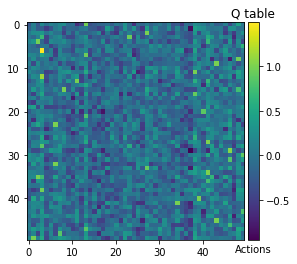

In [44]:
plot_q_table(q_table)

# More work on the algorithm

In [8]:
# Parameters for the deep Q learning algorithm
param_deep_Q = {
    'env' : env,\
    'state_dim' : None ,\
    'name_conversion_state' : None,\
    'mem_size': 50,\
    'gamma' : 0 ,\
    'epsilon' : 0.1,\
    'learning_rate' : 5e-3,\
    'max_iter' : 10 , \
    'batch_size' : 10 ,
    'name' : 'test_model',\
    'model' : LinearModel(1,CATALOGUE_SIZE),\
    'constraints' : False,
    'optimizer' : 'SGD'
}


In [9]:
with open('./check/linear_gamma_0.pickle', 'rb') as f:
    dict_results_linear = pickle.load(f)

In [10]:
# get_result_tables(param_deep_Q, dict_results_linear, names = ['hot_encoding','u_hot','valuable','rewards'],epochs = epochs)

# Loss and rewards for linear model for 10 000 epochs, SGD (learning rate = 5e-3)

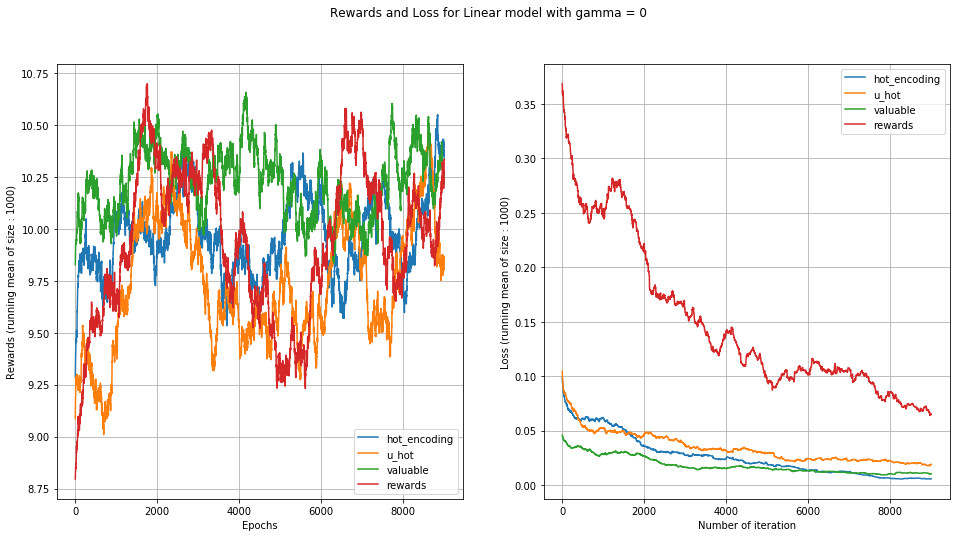

In [11]:
plot_results_loss_rew_dic(dict_results_linear, names = ['hot_encoding','u_hot','valuable','rewards'], rm_rew = 1000, rm_loss = 1000, gamma = 0 )

# Q tables for linear model for 10 000 epochs, SGD (learning rate = 5e-3)

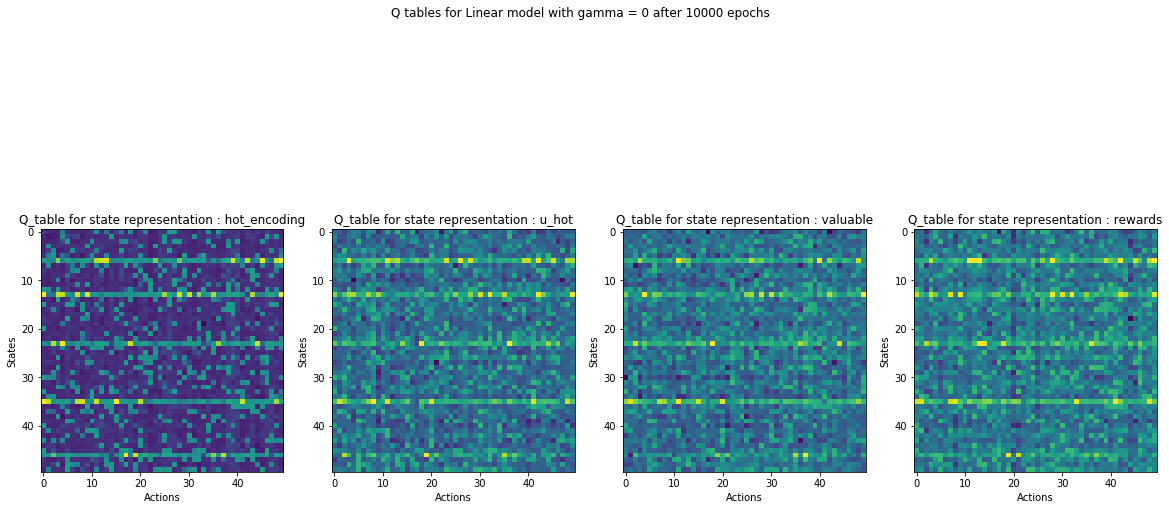

In [12]:
compare_q_tables_dic(dict_results_linear,names = ['hot_encoding','u_hot','valuable','rewards'] , gamma = 0 , isLinear = True) 

# Transpoe of the q tables

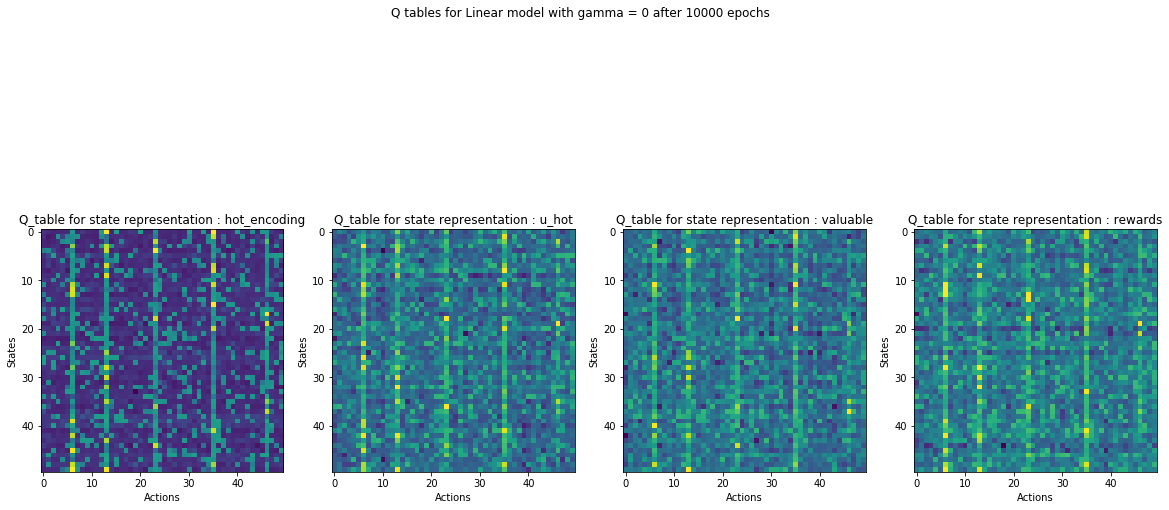

In [13]:
compare_q_tables_dic(dict_results_linear,names = ['hot_encoding','u_hot','valuable','rewards'] , gamma = 0 , isLinear = True, tranpose = True) 

In [39]:
# with open('check/linear_gamma_0.pickle', 'wb') as f:
#     pickle.dump(dict_results_linear, f)

In [44]:
# Parameters for the deep Q learning algorithm
param_deep_Q = {
    'env' : env,\
    'state_dim' : None ,\
    'name_conversion_state' : None,\
    'mem_size': 200,\
    'gamma' : 0.9 ,\
    'epsilon' : 0.1,\
    'learning_rate' : 1e-4,\
    'max_iter' : 10 , \
    'batch_size' : 10 ,
    'name' : 'test_model',\
    'model' : LinearModel(1,CATALOGUE_SIZE),\
    'constraints' : False,
    'optimizer' : 'SGD'
}


In [45]:
# with open('check/dict_results_linear_09.pickle', 'wb') as f:
#     pickle.dump(dict_results_linear_09, f)

In [46]:
dict_results_linear_09 = {}
epochs = [10000]

In [14]:
with open('./check/dict_results_linear_09.pickle', 'rb') as f:
    dict_results_linear_09 = pickle.load(f)

In [47]:
get_result_tables(param_deep_Q, dict_results_linear_09, names = ['hot_encoding', 'u_hot','rewards','valuable'],epochs = epochs)

Episode: 9999/10000, Reward : 24


# Loss and rewards for linear model for 5000 epochs, SGD (learning rate = 5e-6) and gamma = 0.9

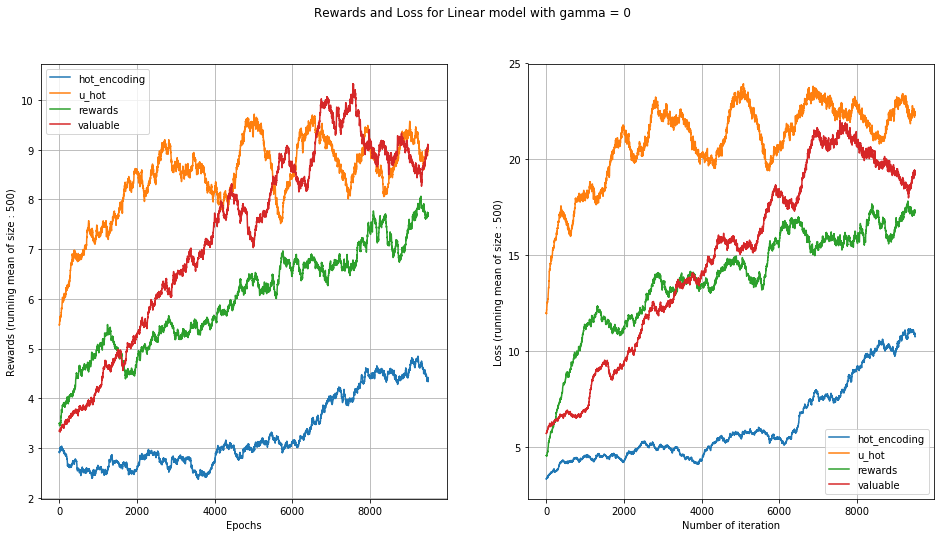

In [50]:
plot_results_loss_rew_dic(dict_results_linear_09, names = ['hot_encoding','u_hot','rewards','valuable'], rm_rew = 500, rm_loss = 500, gamma = 0 )

# Q tables for linear model for 5000 epochs, SGD (learning rate = 5e-6) and gamma = 0.9

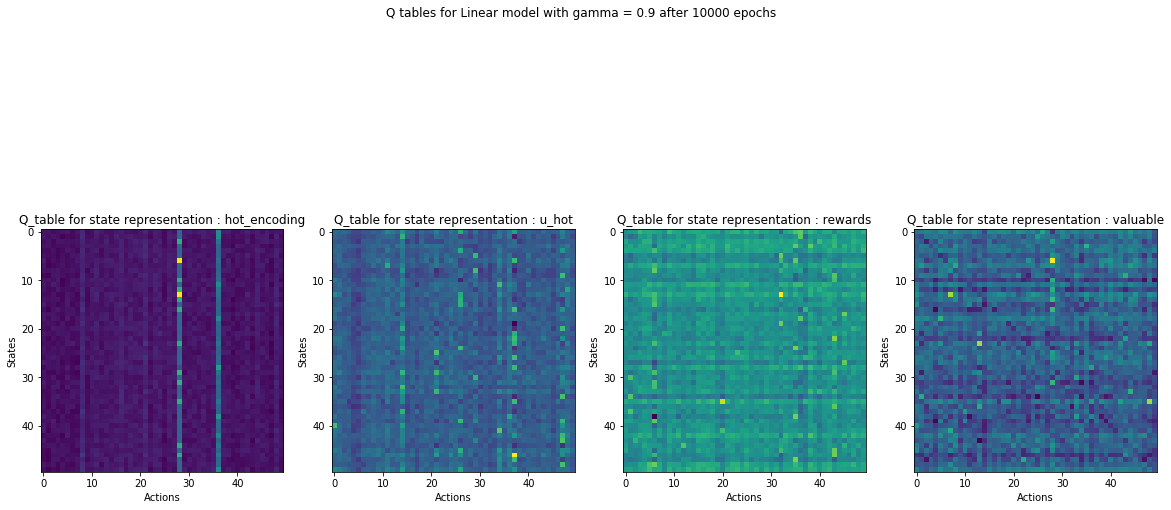

In [51]:
compare_q_tables_dic(dict_results_linear_09,names = ['hot_encoding','u_hot','rewards','valuable'] , gamma = 0.9 , isLinear = True) 

In [52]:
with open('check/dict_results_linear_09.pickle', 'wb') as f:
    pickle.dump(dict_results_linear_09, f)

# Fully connected method

## 1. Gamma = 0, Adam optimizer and learning rate = 5e-4 

In [17]:
# Parameters for the deep Q learning algorithm
param_deep_Q = {
    'env' : env,\
    'state_dim' : None ,\
    'name_conversion_state' : None,\
    'mem_size': 50,\
    'gamma' : 0 ,\
    'epsilon' : 0.1,\
    'learning_rate' : 5e-4,\
    'max_iter' : 10 , \
    'batch_size' : 10 ,
    'name' : 'test_model',\
    'model' : None,\
    'constraints' : False,
    'optimizer' : 'Adam'
}


In [18]:
with open('./check/dict_results_fc.pickle', 'rb') as f:
    dict_results_fc = pickle.load(f)

In [19]:
# get_result_tables(param_deep_Q, dict_results_fc, names = ['valuable', 'hot_encoding','u_hot','rewards'],epochs = epochs, linear = False)

# Loss and rewards for fully connected model for 10 000 epochs, Adam (learning rate = 5e-4)

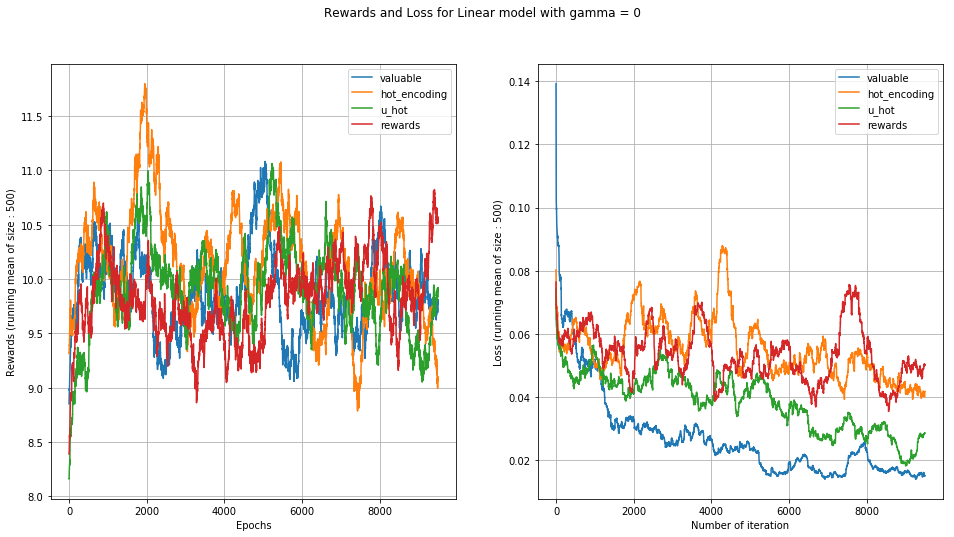

In [20]:
plot_results_loss_rew_dic(dict_results_fc, names = ['valuable', 'hot_encoding','u_hot','rewards'], rm_rew = 500, rm_loss = 500, gamma = 0 )

# Q tables for fully connected model for 10 000 epochs, Adam (learning rate = 5e-4)

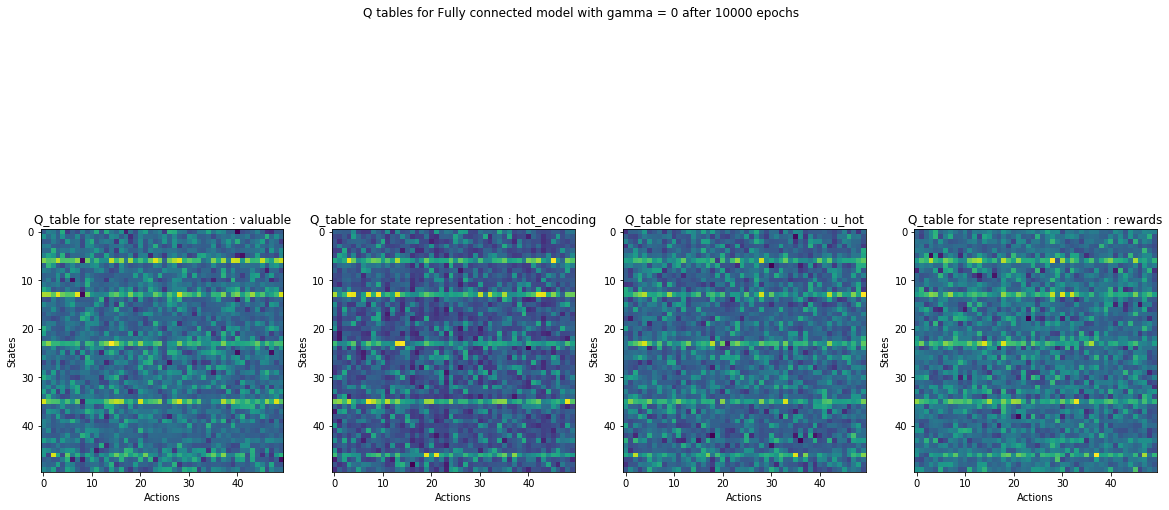

In [23]:
compare_q_tables_dic(dict_results_fc,names = ['valuable', 'hot_encoding','u_hot','rewards'] , gamma = 0 , isLinear = False) 

# Tranposed Q tables for fully connected model for 10 000 epochs, Adam (learning rate = 5e-4)

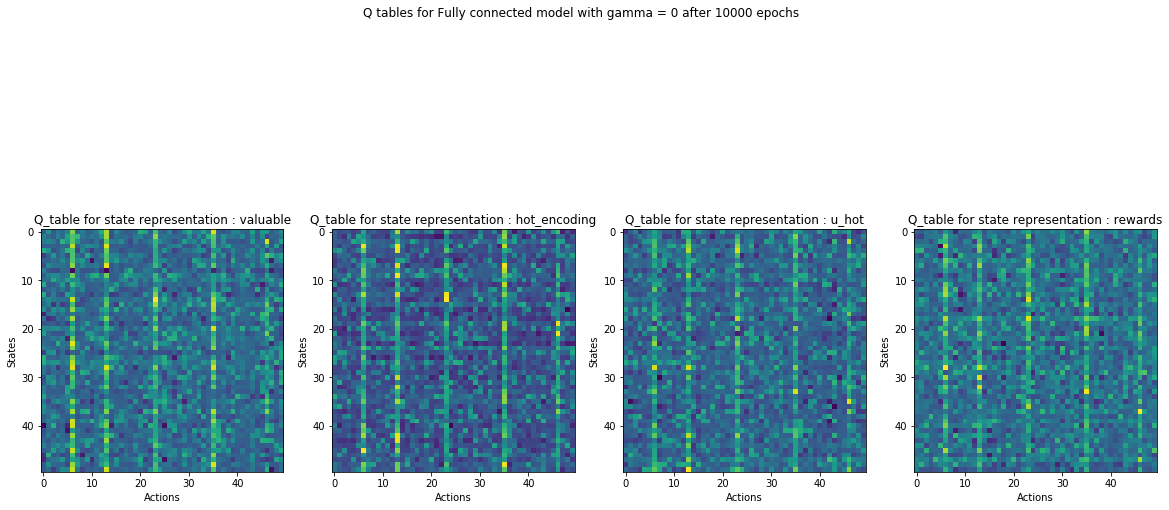

In [24]:
compare_q_tables_dic(dict_results_fc,names = ['valuable', 'hot_encoding','u_hot','rewards'] , gamma = 0 , isLinear = False, tranpose= True) 

In [18]:
# with open('check/dict_results_fc.pickle', 'wb') as f:
#     pickle.dump(dict_results_fc, f)

## 2. Gamma = 0.9, SGD optimizer and learning rate = 1e-4

In [25]:
# Parameters for the deep Q learning algorithm
param_deep_Q = {
    'env' : env,\
    'state_dim' : None ,\
    'name_conversion_state' : None,\
    'mem_size': 200,\
    'gamma' : 0.9 ,\
    'epsilon' : 0.1,\
    'learning_rate' : 1e-4,\
    'max_iter' : 10 , \
    'batch_size' : 10 ,
    'name' : 'test_model',\
    'model' : None,\
    'constraints' : False,
    'optimizer' : 'SGD'
}


In [26]:
names = ['valuable','hot_encoding','u_hot','rewards']

In [27]:
with open('./check/dict_results_fc_09_sgd.pickle', 'rb') as f:
    dict_results_fc_09_sgd = pickle.load(f)

In [15]:
# get_result_tables(param_deep_Q, dict_results_fc_09, names = names,epochs = epochs, linear = False)

Episode: 9999/10000, Reward : 0


# Rewards and Loss for fully connected model for 10 000 epochs, SGD (learning rate = 1e-4) and gamma = 0.9

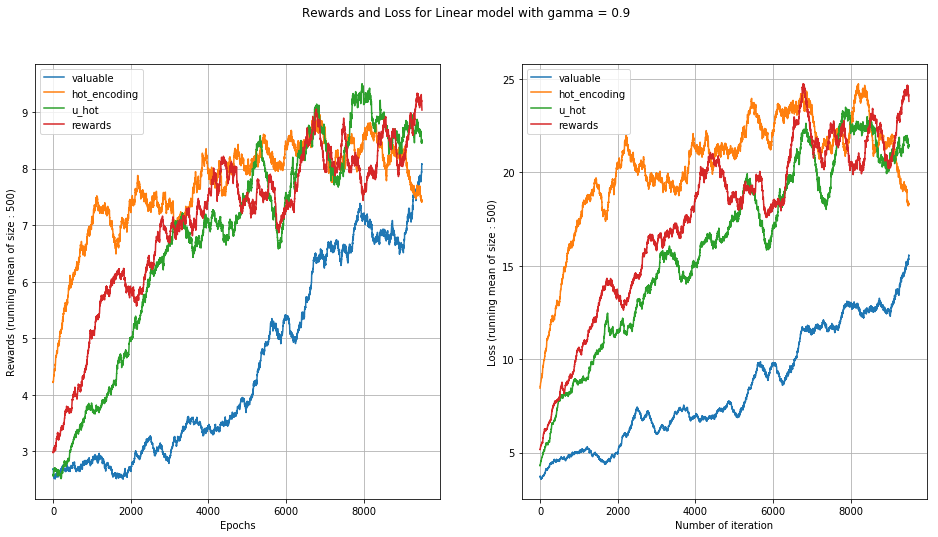

In [41]:
plot_results_loss_rew_dic(dict_results_fc_09_sgd, names =names, rm_rew = 500, rm_loss = 500, gamma = 0.9 )

# Q tables for fully connected model for 10 000 epochs, SGD (learning rate = 1e-4) and gamma = 0.9

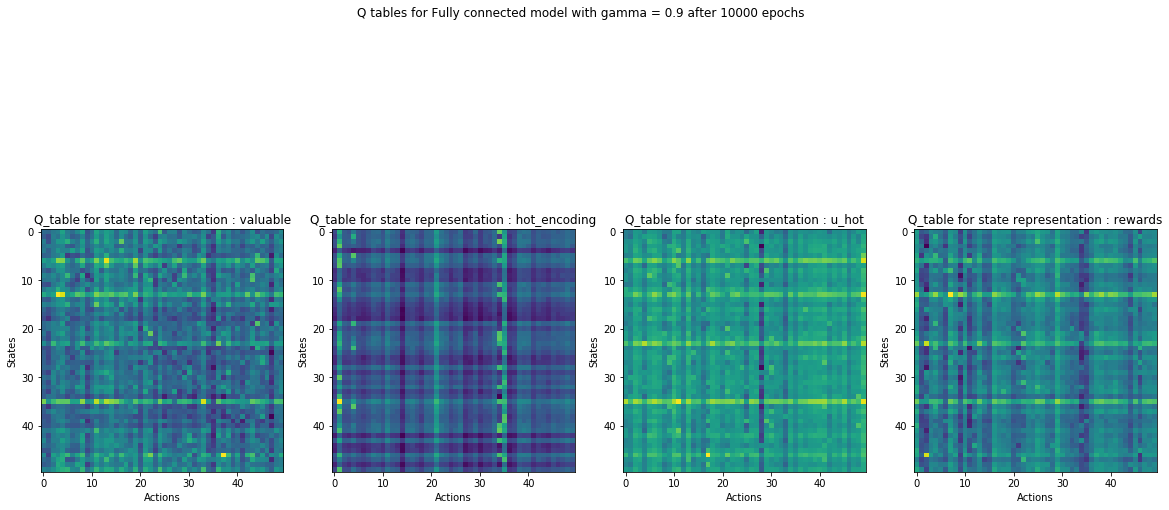

In [29]:
compare_q_tables_dic(dict_results_fc_09_sgd,names = names, gamma = 0.9 , isLinear = False) 

# Transposed Q tables for fully connected model for 10 000 epochs, SGD (learning rate = 1e-4) and gamma = 0.9

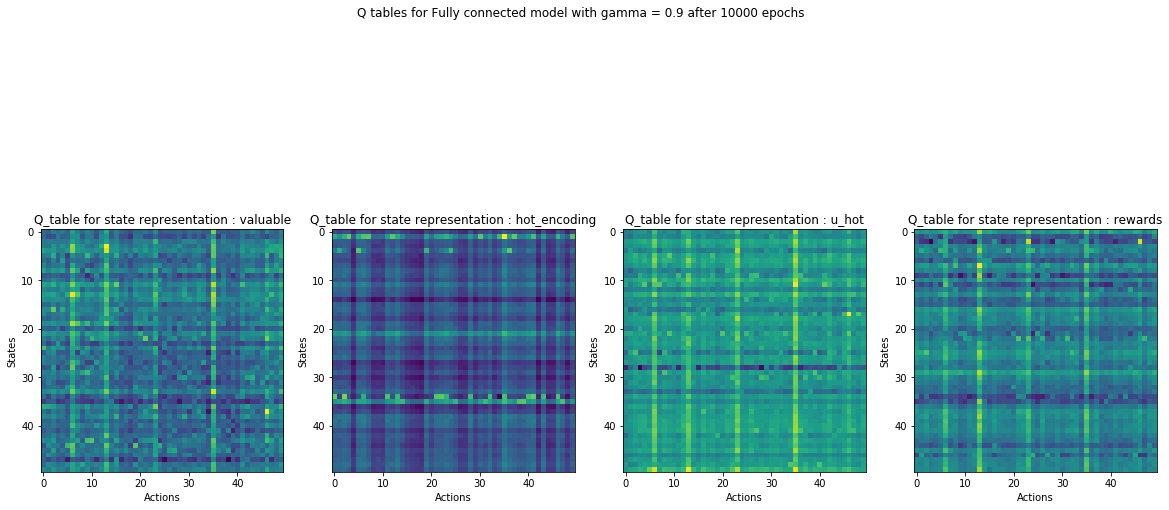

In [30]:
compare_q_tables_dic(dict_results_fc_09_sgd,names = names, gamma = 0.9 , isLinear = False, tranpose = True) 